In [1]:
import random
import time
import datetime
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import numpy as np
import os
from Intelligent_well_control.src.models.utils.save_to_csv import SaveToCsv
from Intelligent_well_control.src.models.LGBM import LGBModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from Intelligent_well_control.src.models.utils.plt import PLT
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv(r'E:\data\压井\新数据\间接数据\大区块数据2.csv')

只要9号区块的

In [3]:
well_id_lists = [11, 17, 21, 111]
data = data[data['well_id'].isin(well_id_lists)]

In [4]:
labels = 'overflow_detected'
rem_col_list = ['id', 'well_id', 'time', 'overflow_flag',
                'work_state', 'invader_type', 'kill_main_method_x',
                'deal_density', 'overflow_detected', 'block_id',
                'standpipe_pressure', 'casing_pressure']
feature_names1 = list(
                filter(lambda x: x not in rem_col_list, data.columns))

In [5]:
model1 = lgb.LGBMClassifier(n_estimators=500)

In [6]:
# 存储每一个井对应的特征排名前20名
well_fea_sort = {}

求每一口井自己的准确率以及特征图

(3174, 385) 11
1.0


C:\Users\admin\AppData\Local\Temp\ipykernel_27260\2778913916.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, orient='h', palette='Set1')


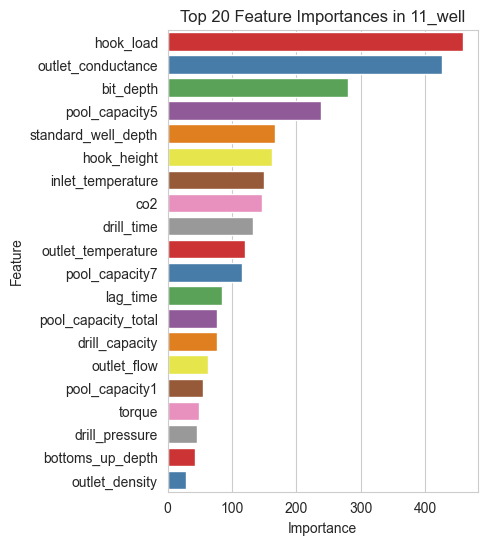

(3933, 385) 17
1.0


C:\Users\admin\AppData\Local\Temp\ipykernel_27260\2778913916.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, orient='h', palette='Set1')


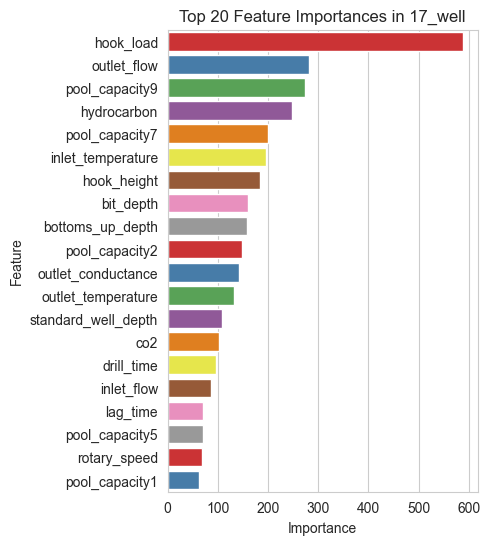

(5805, 385) 21
0.9991386735572783


C:\Users\admin\AppData\Local\Temp\ipykernel_27260\2778913916.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, orient='h', palette='Set1')


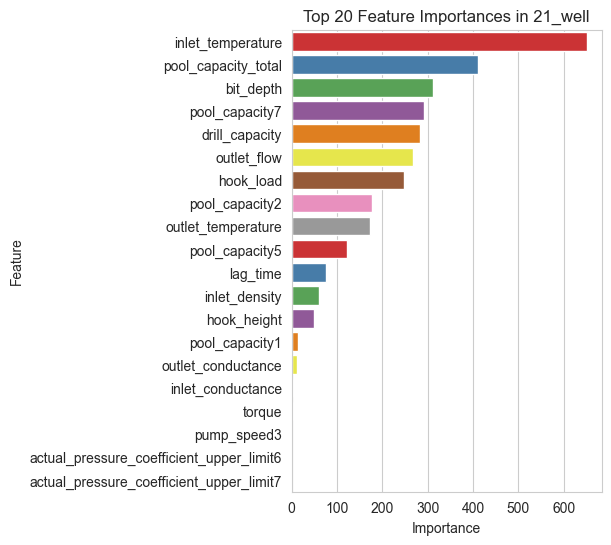

(13844, 385) 111
1.0


C:\Users\admin\AppData\Local\Temp\ipykernel_27260\2778913916.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, orient='h', palette='Set1')


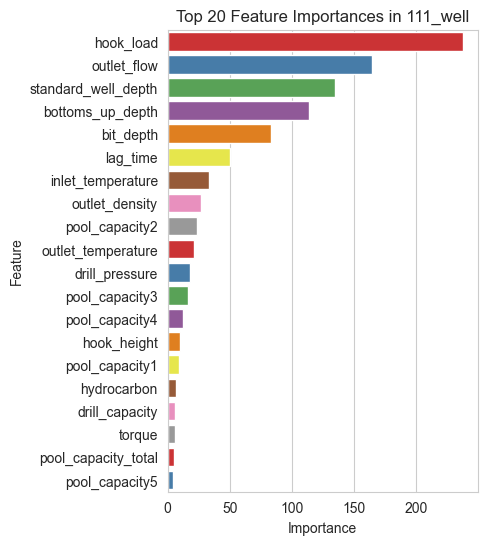

In [7]:
for well_id in well_id_lists:    
    cur_data = data[data['well_id'] == well_id]
    X_train, X_test, Y_train, Y_test = train_test_split(cur_data[feature_names1], cur_data[labels], test_size=0.2, random_state=42)
    print(cur_data.shape, well_id)
    
    model1.fit(X_train, Y_train)

    Y_pred = model1.predict(X_test)
    acc = accuracy_score(Y_pred, Y_test)
    print(acc)
    
    # 画特征图
    feature_names = model1.feature_name_
    feature_importance = model1.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    
    # 按照重要性降序排列
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # 输出前 20 个特征
    top_20_features = feature_importance_df.head(20)
    
    well_fea_sort[well_id] = top_20_features['Feature'].tolist()
    
    plt.figure(figsize=(4, 6))
    sns.barplot(x='Importance', y='Feature', data=top_20_features, orient='h', palette='Set1')
    plt.title('Top 20 Feature Importances in ' + str(well_id) + '_well')
    plt.show()
        

In [8]:
well_fea_sort

{11: ['hook_load',
  'outlet_conductance',
  'bit_depth',
  'pool_capacity5',
  'standard_well_depth',
  'hook_height',
  'inlet_temperature',
  'co2',
  'drill_time',
  'outlet_temperature',
  'pool_capacity7',
  'lag_time',
  'pool_capacity_total',
  'drill_capacity',
  'outlet_flow',
  'pool_capacity1',
  'torque',
  'drill_pressure',
  'bottoms_up_depth',
  'outlet_density'],
 17: ['hook_load',
  'outlet_flow',
  'pool_capacity9',
  'hydrocarbon',
  'pool_capacity7',
  'inlet_temperature',
  'hook_height',
  'bit_depth',
  'bottoms_up_depth',
  'pool_capacity2',
  'outlet_conductance',
  'outlet_temperature',
  'standard_well_depth',
  'co2',
  'drill_time',
  'inlet_flow',
  'lag_time',
  'pool_capacity5',
  'rotary_speed',
  'pool_capacity1'],
 21: ['inlet_temperature',
  'pool_capacity_total',
  'bit_depth',
  'pool_capacity7',
  'drill_capacity',
  'outlet_flow',
  'hook_load',
  'pool_capacity2',
  'outlet_temperature',
  'pool_capacity5',
  'lag_time',
  'inlet_density',
  'h

用其他的井进行训练，来预测当前井，不同特征对比

In [9]:
mx_per_well = {}
det_per_well = {}
# 结构是[acc, Y_pred, Y_test]

In [10]:
for well_id in well_id_lists:
    print(well_id)
    
    mx_per_well[well_id] = [0, 0, 0]
    det_per_well[well_id] = []
    train_well_ids = [i for i in well_id_lists if i != well_id]
    
    print(train_well_ids)
    for i in range(1, 21):
        feature_names2 = well_fea_sort[well_id][:i]
        # print(feature_names2)
        
        X_train = data[data['well_id'].isin(train_well_ids)][feature_names2]
        Y_train = data[data['well_id'].isin(train_well_ids)][labels]
        X_test = data[data['well_id'] == well_id][feature_names2]
        Y_test = data[data['well_id'] == well_id][labels]
        
        model1.fit(X_train, Y_train)
        
        Y_pred = model1.predict(X_test)
        
        acc = np.round(accuracy_score(Y_pred, Y_test), 3)
        print(acc)
        det_per_well[well_id].append(acc)
        if acc > mx_per_well[well_id][0]:
            mx_per_well[well_id] = [acc, Y_pred, Y_test]

11
[17, 21, 111]
0.506
0.455
0.508
0.508
0.493
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
0.49
17
[11, 21, 111]
0.533
0.433
0.433
0.438
0.607
0.306
0.345
0.316
0.316
0.318
0.323
0.302
0.301
0.301
0.303
0.303
0.303
0.296
0.297
0.491
21
[11, 17, 111]
0.309
0.256
0.505
0.505
0.412
0.505
0.505
0.505
0.505
0.505
0.505
0.505
0.501
0.491
0.491
0.491
0.491
0.491
0.491
0.491
111
[11, 17, 21]
0.044
0.149
0.399
0.271
0.271
0.412
0.509
0.572
0.575
0.519
0.593
0.593
0.593
0.202
0.271
0.271
0.255
0.258
0.251
0.243


11 0.508
2369 814


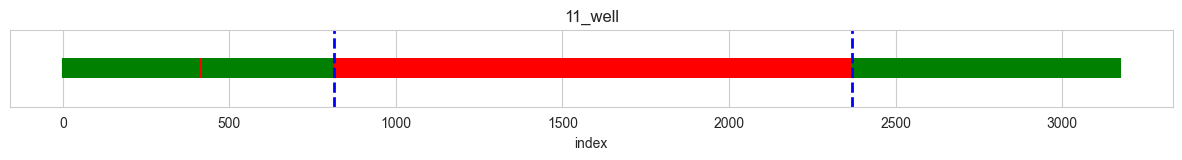

17 0.607
2900 996


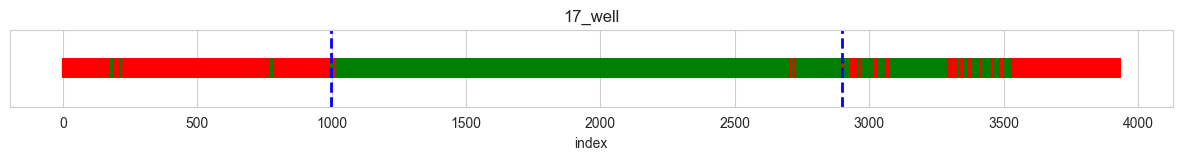

21 0.505
4337 1463


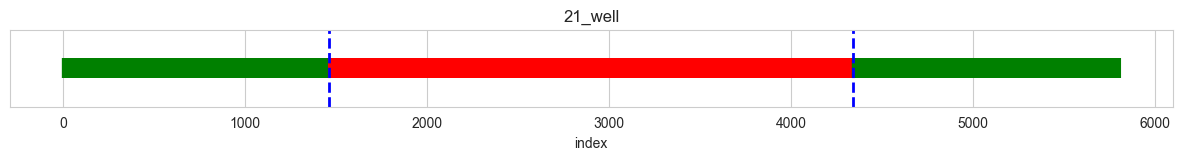

111 0.593
13538 3449


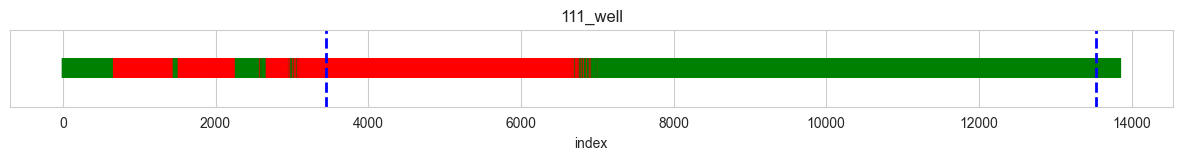

In [22]:
for i in mx_per_well:
    print(i, mx_per_well[i][0])
    PLT().show2(Y_pred = mx_per_well[i][1], Y_true=mx_per_well[i][2], title=str(i) + '_well')

画个折线图

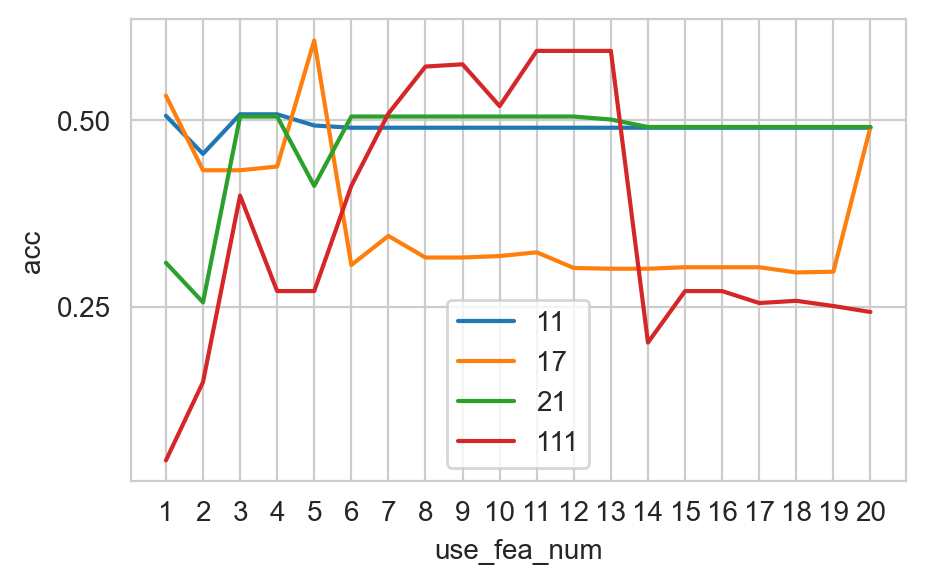

In [19]:
PLT().show_acc(data = det_per_well, y_label='acc', x_label='use_fea_num', xticks=list(range(1, 21)))
# plt.show()

In [ ]:
for 